In [1]:
# import pandas as pd
# import numpy as np
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import SGD, RMSprop, Adam
# from keras.models import load_model

# import tensorflow as tf
# from neupy import algorithms
# from sklearn.metrics import mean_squared_error, confusion_matrix
# from sklearn.metrics import multilabel_confusion_matrix
# from math import sqrt
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import metrics

# # 用隨機森林做Feature Selection
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel

# # ROC Curve
# from scipy import interp
# from itertools import cycle
# from sklearn.metrics import roc_curve, auc

# import re
# from datetime import date
# import datetime

# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

Using TensorFlow backend.


In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

/home/barry/miniconda3/envs/bertenv/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1 匯入資料＆前處理

In [3]:
df = pd.read_csv('data/TCRI_2008_2017.csv', encoding="utf-8")
df = df.sort_values(by=["年月","公司"])   # 先日期排序 再公司名排序
df = df.reset_index(drop=True)           # index重新排序
print(df.shape)
df.head(2)

(2337, 18)


,公司,年月,TCRI,總分,規模,獲利,安全,效率,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收
0,1101 台泥,2008/12/31,3,622.0,140.0,25.0,61.0,85.0,80.43,NaN,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0
1,1201 味全,2008/12/31,5,621.0,105.0,38.0,74.0,78.0,10.75,NaN,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0


In [4]:
df.describe()

,總分,規模,獲利,安全,效率,CFO,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2334.000000,2301.000000,2301.000000,2335.000000,2335.000000
mean,483.451820,68.855675,33.986296,68.811135,39.749465,53.032857,4.941863,3.861251,-1.701443,2.294636,-0.085615,206.398522,71.110921,413.813704
std,293.200973,49.174420,42.023821,60.271720,40.871758,276.646230,139.468763,8.793073,168.423238,1.605054,82.285696,4296.069004,178.469003,1193.327092
min,-1465.000000,0.000000,-60.000000,-888.000000,-40.000000,-190.300000,0.000000,-75.930000,-7928.410000,0.000000,-2280.000000,-8994.000000,-736.000000,0.000000
25%,366.000000,23.000000,0.000000,67.000000,19.000000,0.430000,0.160000,0.390000,-0.065000,1.460000,-4.000000,-5.000000,15.000000,25.000000
50%,529.000000,59.000000,33.000000,87.000000,49.000000,4.950000,0.560000,3.970000,4.620000,2.020000,1.000000,0.000000,42.000000,66.000000
75%,670.000000,122.000000,65.000000,100.000000,70.500000,18.125000,1.420000,7.960000,11.030000,2.830000,6.000000,7.000000,77.000000,209.000000
max,1020.000000,140.000000,120.000000,100.000000,100.000000,5796.730000,6725.280000,95.780000,135.080000,22.460000,2197.000000,90475.000000,4416.000000,12137.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 18 columns):
公司         2337 non-null object
年月         2337 non-null object
TCRI       2336 non-null object
總分         2335 non-null float64
規模         2335 non-null float64
獲利         2335 non-null float64
安全         2335 non-null float64
效率         2335 non-null float64
CFO        2335 non-null float64
CFO不一致     286 non-null object
利息支出率      2335 non-null float64
資產報酬%      2335 non-null float64
營業利益%      2335 non-null float64
借款息%       2334 non-null float64
平均收款天增減    2301 non-null float64
平均售貨天增減    2301 non-null float64
借款依存度%     2335 non-null float64
營收         2335 non-null float64
dtypes: float64(14), object(4)
memory usage: 328.8+ KB


## ※匯入TSE產業別代碼

In [12]:
tse = pd.read_csv('data/TSE_category.csv', encoding="utf-8")
print(tse.shape)
tse.head(2)

(240, 2)


,公司簡稱,TSE 產業別
0,2025 千興,10
1,1453 大將,4


In [13]:
tse.set_index('公司簡稱').to_dict()
tse_dict = tse.set_index('公司簡稱')['TSE 產業別'].to_dict()

In [14]:
tse_no = []
for company in df['公司']:
    tse_no.append(tse_dict[company])
df['TSE產業別'] = tse_no
df.head(2)

,公司,年月,TCRI,總分,規模,獲利,安全,效率,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別
0,1101 台泥,2008/12/31,3,622.0,140.0,25.0,61.0,85.0,80.43,NaN,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0,1
1,1201 味全,2008/12/31,5,621.0,105.0,38.0,74.0,78.0,10.75,NaN,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0,2


In [15]:
df.to_csv('data/TCRI_2008_2017_tse.csv', index=False)

## 1-1 調整「CFO不一致」欄位

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [62]:
df = pd.read_csv('data/TCRI_2008_2017_tse.csv', encoding="utf-8")
df = df.sort_values(by=["年月","公司"])   # 先日期排序 再公司名排序
df = df.reset_index(drop=True)           # index重新排序
print(df.shape)
df.head(2)

(2337, 19)


,公司,年月,TCRI,總分,規模,獲利,安全,效率,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別
0,1101 台泥,2008/12/31,3,622.0,140.0,25.0,61.0,85.0,80.43,NaN,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0,1
1,1201 味全,2008/12/31,5,621.0,105.0,38.0,74.0,78.0,10.75,NaN,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0,2


In [63]:
# 將「CFO不一致」欄位的值調整，空值(Nan)與minus sign(-)改為0，plus sign(+)改為1
df['CFO不一致'] = df['CFO不一致'].fillna(0)
df['CFO不一致'] = df['CFO不一致'].replace('+', 1)
df['CFO不一致'] = df['CFO不一致'].replace('-', 0)

## 1-2 調整「TCRI」欄位

In [64]:
# 將TCRI欄位中"-"資料刪掉；D表示違約，另外處理（先暫時改成0）
index_to_drop = df[df['TCRI'] == '-'].index     # 把 df['TCRI'] == '-' 的index 挑出來
df = df.drop(index=index_to_drop, axis=1)       # 刪除指定index 整個row
df['TCRI'] = df['TCRI'].replace('D', 0)        # D表示違約，另外處理（先暫時改成0）

# TCRI原本有非數值的資料，因此原始的型態並非float64，因此需要轉型
df['TCRI'] = df['TCRI'].astype(float)
print(df.shape)
df.head(2)

(2309, 19)


,公司,年月,TCRI,總分,規模,獲利,安全,效率,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別
0,1101 台泥,2008/12/31,3.0,622.0,140.0,25.0,61.0,85.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0,1
1,1201 味全,2008/12/31,5.0,621.0,105.0,38.0,74.0,78.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0,2


## 1-3 去除空值與非數值型資料

In [65]:
# 有 空值 NaN 的 row橫列 都刪掉
df.dropna(axis=0, inplace=True)
print(df.shape)

(2288, 19)


## 1-4 去除「規模」、「獲利」、「安全」、「效率」等4個欄位

In [66]:
df = df.drop(['規模', '獲利', '安全', '效率'], axis=1)
print(df.shape)
df = df.reset_index(drop=True)           # index重新排序
df.tail(2)

(2288, 15)


,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14


## ※合併輿情風險分數

In [67]:
news_score = pd.read_csv("data/company_year_prob_sum.csv", encoding="utf-8")
news_score["c_0"] = news_score["c_0"].astype(float)  # 讀取後將欄位弄成float
news_score["c_1"] = news_score["c_1"].astype(float)
news_score["c_2"] = news_score["c_2"].astype(float)
news_score["c_3"] = news_score["c_3"].astype(float)
news_score["c_4"] = news_score["c_4"].astype(float)
print(news_score.shape)
news_score.tail(2)

(2400, 7)


,company,date,c_0,c_1,c_2,c_3,c_4
2398,9946 三發地產,2016,0.000002,1.470138e-13,3.596562e-07,4.796958e-23,1.999998e+00
2399,9946 三發地產,2017,1.000000,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


In [68]:
# 把 c_0~c_4都等於0 的index 挑出來
index_to_drop = news_score[(news_score['c_0'] == 0.0) &
                           (news_score['c_1'] == 0.0) &
                           (news_score['c_2'] == 0.0) &
                           (news_score['c_3'] == 0.0) &
                           (news_score['c_4'] == 0.0)].index     # 把 c_0~c_4都等於0 的 row的 index 挑出來
print(len(index_to_drop))
index_to_drop

1972


Int64Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   11,
            ...
            2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397],
           dtype='int64', length=1972)

In [69]:
news_score = news_score.drop(index=index_to_drop, axis=1)       # 刪除指定index 整個row
news_score = news_score.reset_index(drop=True)           # index重新排序
print(news_score.shape)
news_score.tail(2)

(428, 7)


,company,date,c_0,c_1,c_2,c_3,c_4
426,9946 三發地產,2016,0.000002,1.470138e-13,3.596562e-07,4.796958e-23,1.999998e+00
427,9946 三發地產,2017,1.000000,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


#### 因為df 的row數 跟 news_score不一樣
#### 比對 company和year 再把 news_score表格的欄位 填入 df 表格

In [70]:
# # M106陳柏霖寫法

# risk1 = []
# risk2 = []
# risk3 = []
# risk4 = []
# risk5 = []
# risk6 = []
# # 年份跟公司也append，方便確認每家公司的風險分數沒有對應錯誤
# year_from_news_score = []
# company_from_news_score = []

# for i in range(len(df)):
#     s = df['年月'].iloc[i]
#     match = re.search('\d+/\d+/\d+', s)
#     date = datetime.datetime.strptime(match.group(0), '%Y/%m/%d').date()
#     year = date.year
#     company = df['公司'].iloc[i]
#     isInsert = False
#     for j in range(len(news_score)):
#         if (year == news_score['Year'].iloc[j]) and (company == news_score['company'].iloc[j]):
#             risk1.append(np.float64(news_score['0'].iloc[j]))
#             risk2.append(np.float64(news_score['1'].iloc[j]))
#             risk3.append(np.float64(news_score['2'].iloc[j]))
#             risk4.append(np.float64(news_score['3'].iloc[j]))
#             risk5.append(np.float64(news_score['4'].iloc[j]))
#             risk6.append(np.float64(news_score['5'].iloc[j]))
#             year_from_news_score.append(news_score['Year'].iloc[j])
#             company_from_news_score.append(news_score['company'].iloc[j])
#             isInsert = True
#     if not isInsert:
#         risk1.append(0.0)
#         risk2.append(0.0)
#         risk3.append(0.0)
#         risk4.append(0.0)
#         risk5.append(0.0)
#         risk6.append(0.0)
#         year_from_news_score.append(0)
#         company_from_news_score.append('NO')

In [71]:
# # M106陳柏霖寫法

# df['財務風險'] = risk1
# df['管理風險'] = risk2
# df['法律風險'] = risk3
# df['供應鏈風險'] = risk4
# df['誠信風險'] = risk5
# df['勞動風險'] = risk6
# df['year'] = year_from_news_score
# df['company'] = company_from_news_score
# df.tail()

In [72]:
df["c_0"] = 0.0
df["c_1"] = 0.0
df["c_2"] = 0.0
df["c_3"] = 0.0
df["c_4"] = 0.0
df.tail(2)

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16,0.0,0.0,0.0,0.0,0.0
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,0.0,0.0,0.0,0.0,0.0


In [73]:
company_list = news_score["company"].astype(str).unique()  # 把欄位unique的值都挑出來變成numpy
print(len(company_list))
company_list[:10]

240


array(['1101 台泥', '1201 味全', '1210 大成', '1215 卜蜂', '1216 統一', '1218 泰山',
       '1220 台榮', '1227 佳格', '1232 大統益', '1233 天仁'], dtype=object)

In [74]:
# news_score表格 取出"company" contains"三發地產" 並且 "date" contains 2017的表格
df_temp = news_score.loc[(news_score["company"].str.contains("三發地產"))
                          & (news_score["date"].astype(str).str.contains( str(2017) ))]
df_temp

,company,date,c_0,c_1,c_2,c_3,c_4
427,9946 三發地產,2017,1.0,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


In [75]:
# df_temp c_0欄位取值 用sum是因為有時候會遇到df_temp表格是空的
df_temp["c_0"].sum()  

1.0

In [76]:
# df表格 取出"company" contains"三發地產" 並且 "date" contains 2017的表格
df.loc[(df["公司"].astype(str).str.contains("三發地產") )
                      & (df["年月"].astype(str).str.contains( str(2017) ))]

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,0.0,0.0,0.0,0.0,0.0


In [77]:
# df表格 取出"company" contains"三發地產" 並且 "date" contains 2017的表格 的 c_0欄位 = df_temp["c_0"].sum()
df.loc[(df["公司"].astype(str).str.contains("三發地產") )
                      & (df["年月"].astype(str).str.contains( str(2017) )), "c_0"] = df_temp["c_0"].sum()
df.tail(2)

,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16,0.0,0.0,0.0,0.0,0.0
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,1.0,0.0,0.0,0.0,0.0


In [78]:
# # 用pandas兩個欄位的for loop應該比較快 但我懶惰重新寫
# for company_name, year in tqdm(news_score[["company", "date"]].to_numpy(), total=428):
#     print(company_name, year)

In [79]:
# 把上面寫成for loop
# for 240公司名list:
#     for 2008-2017年:

for company_name in tqdm(company_list):
    for year in range(2008,2018):
        company_name = str(company_name)
        
        # news_score 取出 company欄位 contains 公司名 & date欄位 contains 年分 
        df_temp = news_score.loc[(news_score["company"].str.contains(company_name))
                       & (news_score["date"].astype(str).str.contains( str(year) ))]


        # 將 c_0 ~ c_4 欄位 
        # 按照 公司名 年分 填入 df 的 c_0 ~ c_4 欄位表格
        df.loc[(df["公司"].astype(str).str.contains(company_name) )
                    & (df["年月"].astype(str).str.contains( str(year) )), "c_0"] = df_temp["c_0"].sum()
        df.loc[(df["公司"].astype(str).str.contains(company_name) )
                    & (df["年月"].astype(str).str.contains( str(year) )), "c_1"] = df_temp["c_1"].sum()
        df.loc[(df["公司"].astype(str).str.contains(company_name) )
                    & (df["年月"].astype(str).str.contains( str(year) )), "c_2"] = df_temp["c_2"].sum()
        df.loc[(df["公司"].astype(str).str.contains(company_name) )
                    & (df["年月"].astype(str).str.contains( str(year) )), "c_3"] = df_temp["c_3"].sum()
        df.loc[(df["公司"].astype(str).str.contains(company_name) )
                    & (df["年月"].astype(str).str.contains( str(year) )), "c_4"] = df_temp["c_4"].sum()

df.tail(2)

100%|██████████| 240/240 [00:37<00:00,  6.48it/s]


,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,1.0,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


### 因為有些年有些公司沒有文章 看機率全為0.0的有幾筆

In [80]:
# 把 c_0~c_4都等於0 的index 挑出來
index_to_drop = df[(df['c_0'] == 0.0) &
                   (df['c_1'] == 0.0) &
                   (df['c_2'] == 0.0) &
                   (df['c_3'] == 0.0) &
                   (df['c_4'] == 0.0)].index     # 把 c_0~c_4都等於0 的 row的 index 挑出來
print(len(index_to_drop))
index_to_drop

1872


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2275, 2276, 2277, 2278, 2279, 2280, 2283, 2284, 2285, 2286],
           dtype='int64', length=1872)

In [81]:
df2 = df.drop(index=index_to_drop, axis=1)       # 刪除指定index 整個row
df2 = df2.reset_index(drop=True)           # index重新排序
print(df2.shape)
del df2

(416, 20)


In [82]:
df.to_csv('data/TCRI_2008_2017_prob.csv', index=False)

# 2 Feature Engineering

## 2-1 根據基本總分產生的初步TCRI等級

In [83]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [84]:
df = pd.read_csv("data/TCRI_2008_2017_prob.csv", encoding="utf-8")
df["c_0"] = df["c_0"].astype(float)  # 讀取後將欄位弄成float
df["c_1"] = df["c_1"].astype(float)
df["c_2"] = df["c_2"].astype(float)
df["c_3"] = df["c_3"].astype(float)
df["c_4"] = df["c_4"].astype(float)
df["TCRI"] = df["TCRI"].astype(float)
print(df.shape)
df.tail(2)

(2288, 20)


,公司,年月,TCRI,總分,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4
2286,9943 好樂迪,2017/12/29,5.0,711.0,5.20,0,0.00,15.93,17.41,6.53,1.0,0.0,0.0,29.0,16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2287,9946 三發地產,2017/12/29,7.0,243.0,-8.71,1,7.49,3.83,20.42,2.51,9.0,1437.0,102.0,17.0,14,1.0,1.433146e-20,1.467837e-13,2.940595e-25,2.578725e-17


In [85]:
def transformBasicTCRILevel(value):
    level = 0
    if value < 165.0:
        level = 9
    elif value < 250.0:
        level = 8
    elif value < 335.0:
        level = 7
    elif value < 420.0:
        level = 6
    elif value < 505.0:
        level = 5
    elif value < 590.0:
        level = 4
    elif value < 675.0:
        level = 3
    elif value < 760.0:
        level = 2
    else:
        level = 1
    return level

In [86]:
basicTCRI = []
for score in df['總分']:
    basicTCRI.append(transformBasicTCRILevel(score))

In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(basicTCRI, df['TCRI']))
print(rmse)

2.3138757483972596


In [88]:
# 用初步等級將總分替換
df.drop(['總分'], axis=1, inplace=True)
df['初步等級'] = basicTCRI
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,平均售貨天增減,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,-2.0,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,1.0,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,-9.0,43.0,712.0,2,0.0,0.0,0.0,0.0,0.0,2
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,-1.0,38.0,154.0,2,0.0,0.0,0.0,0.0,0.0,4
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,1.0,125.0,2997.0,2,0.0,0.0,0.0,0.0,0.0,3


## 2-2 門檻等級：規模

In [89]:
thresholdLevel = []
for i in range(len(df)):
    rev = df['營收'].iloc[i]
    level = df['初步等級'].iloc[i]
    threshold = 0
    
    # 營收不到5億，則不列入前5等；電子業門檻較高，門檻為10億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 10
    else:
        threshold = 5
    if rev < threshold and level <= 5:
        level = 6
        
    # 營收不到10億，則不列入前4等；電子業門檻較高，門檻為20億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 20
    else:
        threshold = 10
    if rev < threshold and level <= 4:
        level = 5
    
    # 營收不到30億，則不列入前3等；電子業門檻較高，門檻為40億
    if df['TSE產業別'].iloc[i] == 28: # 電子零組件業產業別代碼為28
        threshold = 40
    else:
        threshold = 30
    if rev < threshold and level <= 3:
        level = 4
        
    # 營收不到100億，則不列入前2等
    threshold = 100
    if rev < threshold and level <= 2:
        level = 3
        
    # 營收不到200億，則不列入前1等
    threshold = 200
    if rev < threshold and level <= 1:
        level = 2
    
    # 補充電子業門檻較高原因：受景氣影響較深，除非擁有關鍵技術或特殊的利基市場、獨門生意，否則一律適用較嚴格的規模門檻。
    
    thresholdLevel.append(level)

df['門檻等級_規模'] = thresholdLevel
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3,3
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3,3
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,...,43.0,712.0,2,0.0,0.0,0.0,0.0,0.0,2,2
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,...,38.0,154.0,2,0.0,0.0,0.0,0.0,0.0,4,4
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,...,125.0,2997.0,2,0.0,0.0,0.0,0.0,0.0,3,3


## 2-2 APL 財務壓力計

### 2-2-1 Assets Management

In [ ]:
# 確認有無離群值
plt.subplot(1, 2, 1)
plt.boxplot(df['平均收款天增減'])
plt.subplot(1, 2, 2)
plt.boxplot(df['平均售貨天增減'])
plt.tight_layout()

In [90]:
from scipy import stats
index_temp_1 = df[(np.abs(stats.zscore(df['平均收款天增減'])) > 3)].index
index_temp_2 = df[(np.abs(stats.zscore(df['平均售貨天增減'])) > 3)].index
# display(index_temp_1)
# display(index_temp_2)

# 聯集：讓index不重複
def find_union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2)) 
    return final_list

index_to_drop = find_union(index_temp_1, index_temp_2)

df.drop(index=index_to_drop, axis=1, inplace=True)
df.head(2)

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,借款依存度%,營收,TSE產業別,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,88.0,785.0,1,0.0,0.0,0.0,0.0,0.0,3,3
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,63.0,202.0,2,0.0,0.0,0.0,0.0,0.0,3,3


In [ ]:
plt.subplot(1, 2, 1)
plt.boxplot(df['平均收款天增減'])
plt.subplot(1, 2, 2)
plt.boxplot(df['平均售貨天增減'])
plt.tight_layout()

In [91]:
# A1. 平均收帳天數比前一期慢 >= 20 天
# df[df['平均收款天增減'] >= 20]
A1 = []
for d in df['平均收款天增減']:
    if d >= 20:
        A1.append(int(d / 20))
    else:
        A1.append(0)
df['A1'] = A1

In [92]:
# A3. 平均售貨天數比前一期慢 >= 20 天
A3 = []
for d in df['平均售貨天增減']:
    if d >= 20:
        A3.append(int(d / 20))
    else:
        A3.append(0)
df['A3'] = A3

### 2-2-2 Profitability

In [93]:
# P1. 當期的總資產報酬率(ROA)不敷借款息
# df[df['資產報酬%'] - df['借款息%'] <= 0]
P1 = []
for i in range(len(df)):
    if df['資產報酬%'].iloc[i] - df['借款息%'].iloc[i] <= 0:
        P1.append(True)
    else:
        P1.append(False)

In [94]:
# P2. 當期的營業利益率(OP%)不足支應利息支出率(INT%)
# df[df['營業利益%'] - df['利息支出率'] <= 0]
P2 = []
for i in range(len(df)):
    if df['營業利益%'].iloc[i] - df['利息支出率'].iloc[i] <= 0:
        P2.append(True)
    else:
        P2.append(False)

In [95]:
'''
P發生的case
(1) P1且P2
(2) 連續3期P1（先略過）
'''
P_case1 = []
for i in range(len(df)):
    if P1[i] and P2[i]:
        P_case1.append(1)
    else:
        P_case1.append(0)
df['P'] = P_case1
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,c_0,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,...,0.0,0.0,0.0,0.0,0.0,2,2,0,0,0
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,...,0.0,0.0,0.0,0.0,0.0,4,4,0,0,0
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,...,0.0,0.0,0.0,0.0,0.0,3,3,0,0,0


### 2-2-3 Liquidity

In [96]:
# L1. 借款依存度(DE%)超過100%
# df[df['借款依存度%'] > 100]
L1 = []
for l in df['借款依存度%']:
    if l > 100:
        L1.append(1)
    else:
        L1.append(0)
df['L1'] = L1
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,c_1,c_2,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P,L1
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,0.0,0.0,0.0,0.0,3,3,0,0,0,0
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,0.0,0.0,0.0,0.0,3,3,0,0,0,0
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,...,0.0,0.0,0.0,0.0,2,2,0,0,0,0
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,...,0.0,0.0,0.0,0.0,4,4,0,0,0,0
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,...,0.0,0.0,0.0,0.0,3,3,0,0,0,1


In [97]:
# L3. CFO為負，不足資金 < -0.25億
# df[df['CFO'] < -0.25]
L3 = []
for l in df['CFO']:
    if l < 0.25:
        L3.append(1)
    else:
        L3.append(0)
df['L3'] = L3
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,c_2,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P,L1,L3
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,0.0,0.0,0.0,3,3,0,0,0,0,0
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,0.0,0.0,0.0,3,3,0,0,0,0,0
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,...,0.0,0.0,0.0,2,2,0,0,0,0,0
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,...,0.0,0.0,0.0,4,4,0,0,0,0,0
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,...,0.0,0.0,0.0,3,3,0,0,0,1,0


In [98]:
df.head()

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,c_2,c_3,c_4,初步等級,門檻等級_規模,A1,A3,P,L1,L3
0,1101 台泥,2008/12/31,3.0,80.43,0,3.51,2.93,6.64,3.72,-2.0,...,0.0,0.0,0.0,3,3,0,0,0,0,0
1,1201 味全,2008/12/31,5.0,10.75,0,0.54,4.62,4.04,3.27,-2.0,...,0.0,0.0,0.0,3,3,0,0,0,0,0
2,1210 大成,2008/12/31,4.0,23.25,0,0.42,5.93,1.96,4.42,-5.0,...,0.0,0.0,0.0,2,2,0,0,0,0,0
3,1215 卜蜂,2008/12/31,4.0,1.77,0,0.27,5.49,2.37,3.73,0.0,...,0.0,0.0,0.0,4,4,0,0,0,0,0
4,1216 統一,2008/12/31,4.0,178.78,0,1.38,4.02,4.95,3.56,-1.0,...,0.0,0.0,0.0,3,3,0,0,0,1,0


## 2-3 人工解讀

### 2-3-1 人工解讀<b>產業前景</b>與<b>經營層風險</b>

# 3 訓練前的準備

## 3-1 Resample imbalanced labels
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [103]:
df['TCRI'].value_counts()

4.0    509
5.0    440
6.0    398
7.0    270
3.0    206
8.0    168
9.0    102
0.0     80
2.0     45
1.0     40
Name: TCRI, dtype: int64

In [ ]:
df['TCRI'].value_counts().plot(kind='bar')

In [104]:
# Class count
count_TCRI_4 = len(df[df['TCRI'] == 4])


# Divide by class
df_TCRI_0 = df[df['TCRI'] == 0.0]
df_TCRI_1 = df[df['TCRI'] == 1]
df_TCRI_2 = df[df['TCRI'] == 2]
df_TCRI_3 = df[df['TCRI'] == 3]
df_TCRI_4 = df[df['TCRI'] == 4]
df_TCRI_5 = df[df['TCRI'] == 5]
df_TCRI_6 = df[df['TCRI'] == 6]
df_TCRI_7 = df[df['TCRI'] == 7]
df_TCRI_8 = df[df['TCRI'] == 8]
df_TCRI_9 = df[df['TCRI'] == 9]

In [105]:
# 把每個類別都複製到跟4類別一樣多

df_TCRI_0_over = df_TCRI_0.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_1_over = df_TCRI_1.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_2_over = df_TCRI_2.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_3_over = df_TCRI_3.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_5_over = df_TCRI_5.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_6_over = df_TCRI_6.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_7_over = df_TCRI_7.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_8_over = df_TCRI_8.sample(n=count_TCRI_4, replace=True, random_state=2018, )
df_TCRI_9_over = df_TCRI_9.sample(n=count_TCRI_4, replace=True, random_state=2018, )

In [106]:
# 新的複製的data 合併
df_resample = pd.concat([df_TCRI_0_over, df_TCRI_1_over, df_TCRI_2_over, df_TCRI_3_over, df_TCRI_4, df_TCRI_5_over, df_TCRI_6_over, df_TCRI_7_over, df_TCRI_8_over, df_TCRI_9_over])
df_resample['TCRI'].value_counts()

9.0    509
8.0    509
7.0    509
6.0    509
5.0    509
4.0    509
3.0    509
2.0    509
1.0    509
0.0    509
Name: TCRI, dtype: int64

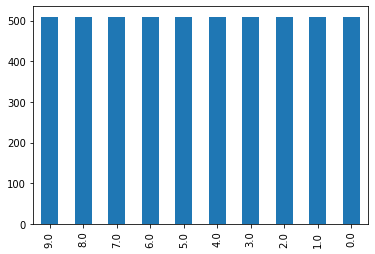

In [39]:
df_resample['TCRI'].value_counts().plot(kind='bar')

## 3-2 資料前處理 function

In [125]:
def dataPreprocessing(df, IsSelected, HasCrisis, GenMoreData):
    # 3-1 區分Feature (X) 跟Label (Y)
    Y = df['TCRI'].values
    
    if HasCrisis:
        X = df.drop(['TCRI', '公司', '年月'], axis = 1).values
    else:
        X = df.drop(['TCRI', '公司', '年月', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4' ], axis = 1).values
    
    if IsSelected: # Feature Selection with Random Forest
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X, Y)
        model = SelectFromModel(clf, prefit=True)
        X = model.transform(X)
        X.shape
    
    # 3-2 標準化
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_minmax = minmax_scale.fit_transform(X)
    X_minmax.shape
    
    # 3-3 Label要轉成二進位的matrix，才能使用categorical_crossentropy
    from tensorflow.keras.utils import to_categorical
    y = to_categorical(Y)
    
    # 3-4 Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, random_state=42)
    
    # 3-5 拿training data的10%作為Validation Split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    # 3-5 產生更多data
    for i in range(GenMoreData):
        X_train = np.append(X_train, X_train, axis=0)
        X_test = np.append(X_test, X_test, axis=0)
        X_val = np.append(X_val, X_val, axis=0)
        y_train = np.append(y_train, y_train, axis=0)
        y_test = np.append(y_test, y_test, axis=0)
        y_val = np.append(y_val, y_val, axis=0)
    
    return X_train, X_test, y_train, y_test, X_val, y_val

# 4 訓練MLP模型

In [153]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification, AdamW

from tensorflow import keras
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, Dropout, Activation, Flatten, InputLayer
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [113]:
# # 如果GPU被占用
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# session = tf.Session(config=config)

In [132]:
def MLP_model(INPUT_DIM, OUTPUT_DIM):
    model = Sequential()
    model.add(Dense(units=64, input_dim=INPUT_DIM, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(units=OUTPUT_DIM, activation='softmax'))
    model.summary()
    
    return model

In [43]:
def show_train_history(train_history, train_key, val_key):
    plt.plot(train_history.history[train_key])
    plt.plot(train_history.history[val_key])
    plt.title('Model accuracy' if 'acc' in train_key else 'Model loss')
    plt.ylabel('accuracy' if 'acc' in train_key else 'loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.plot()

In [133]:
X_train, X_test, y_train, y_test, X_val, y_val = dataPreprocessing(df_resample, IsSelected=False, HasCrisis=True, GenMoreData=6)

In [134]:
display(X_train.shape[1])

23

In [167]:
%%time
model = MLP_model(X_train.shape[1], y_train.shape[1])
# EPOCHS = 100
# LR = 0.1
# DECAY = LR / EPOCHS
# MOMENTUM = 0.8
# SGD = SGD(lr=LR, momentum=MOMENTUM, decay=DECAY, nesterov=False)
# ADAM = Adam(lr=LR, decay=DECAY)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1536      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 3,946
Trainable params: 3,946
Non-trainable params: 0
_________________________________________________________________
Train on 234496 samples, validate on 26112 samples
Epoch 1/50
234496/234496 [==============================] - 17s 74us/sample - loss: 1.1672 - categorical_accuracy: 0.5063 - val_loss: 1.0873 - val_categorical_accuracy: 0.5515
Epoch 2/50
234496/23449

In [47]:
# model.save('Model/TCRI/MLP_64units_32units_0517_sentiment.h5')

In [172]:
X_train_RF, X_test_RF, y_train_RF, y_test_RF, X_val_RF, y_val_RF = dataPreprocessing(df_resample, IsSelected=False, HasCrisis=False, GenMoreData=6)

In [173]:
display(X_train_RF.shape[1])

18

In [174]:
%%time
model_RF = MLP_model(X_train_RF.shape[1], y_train_RF.shape[1])
# OPTIMIZER = Adam(lr=0.001)
model_RF.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history_RF = model_RF.fit(x=X_train_RF, y=y_train_RF, validation_data=(X_val_RF, y_val_RF), epochs=50, batch_size=16, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
Total params: 3,626
Trainable params: 3,626
Non-trainable params: 0
_________________________________________________________________
Train on 234496 samples, validate on 26112 samples
Epoch 1/50
234496/234496 [==============================] - 17s 73us/sample - loss: 1.2199 - categorical_accuracy: 0.4902 - val_loss: 1.1822 - val_categorical_accuracy: 0.5123
Epoch 2/50
234496/23449

In [51]:
# model_RF.save('Model/TCRI/MLP_64units_32units_0513_withoutsent.h5')

# 5 評估模型與預測

## 5-1 載入模型

In [52]:
# 載入先前已經訓練好的模型
# model = load_model('Model/TCRI/MLP_64units_32units_0513_sentiment.h5')
best_model = load_model('Model/TCRI/MLP_64units_32units_0513_sentiment.h5')

## 5-2 評估模型

### 5-2-1 有輿情

In [ ]:
# show_train_history(history, 'categorical_accuracy', 'val_categorical_accuracy')
scores = model.evaluate(X_test, y_test)
print(scores)

In [176]:
y_pred = model.predict_classes(X_test)
y_pred

array([1, 5, 0, ..., 2, 7, 5])

In [177]:
y_test_classes = np.argmax(y_test, axis=1)
y_test_classes

array([1, 5, 0, ..., 2, 7, 6])

In [59]:
# np.argmax(y_test, axis=1)

In [178]:
print(accuracy_score(y_test_classes, y_pred))
print(confusion_matrix(y_test_classes, y_pred))
print(classification_report(y_test_classes, y_pred))

0.8035363457760314
[[7168    0    0    0    0    0    0    0  128    0]
 [   0 6656    0    0    0    0    0    0    0    0]
 [   0    0 6912    0    0    0    0    0    0    0]
 [   0    0  256 4544  384  256    0    0    0    0]
 [   0   64   64 1024 3200 1088  256    0    0    0]
 [   0    0    0  192  832 4224  768  448    0    0]
 [   0    0    0    0  128 1664 3584 1216   64   64]
 [   0    0    0   64  192  256  448 4608  256  256]
 [  64    0    0    0    0  128  192  512 5440  256]
 [1024    0    0    0    0    0    0  256    0 6016]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7296
           1       0.99      1.00      1.00      6656
           2       0.96      1.00      0.98      6912
           3       0.78      0.84      0.81      5440
           4       0.68      0.56      0.61      5696
           5       0.55      0.65      0.60      6464
           6       0.68      0.53      0.60      6720
           7     

### Confusion Matrix

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), y_pred), cmap='YlGnBu')

In [64]:
pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=1), y_pred)).to_csv('TCRI/ConfusionMatrix_Sentiment.csv')

### 畫ROC Curve（有輿情）

In [82]:
n_classes = 10

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### 5-2-2 沒有輿情

In [65]:
# 載入先前已經訓練好的模型
# model_RF = load_model('Model/TCRI/MLP_64units_32units_0513_withoutsent.h5')

In [ ]:
# show_train_history(history_RF, 'categorical_accuracy', 'val_categorical_accuracy')
scores_RF = model_RF.evaluate(X_test_RF, y_test_RF)
print(scores_RF)

In [179]:
y_pred_RF = model_RF.predict_classes(X_test_RF)
y_pred_RF

array([1, 5, 0, ..., 2, 7, 5])

In [180]:
y_test_RF_classes = np.argmax(y_test_RF, axis=1)
y_test_RF_classes

array([1, 5, 0, ..., 2, 7, 6])

In [181]:
print(accuracy_score(y_test_RF_classes, y_pred_RF))
print(confusion_matrix(y_test_RF_classes, y_pred_RF))
print(classification_report(y_test_RF_classes, y_pred_RF))

0.806483300589391
[[7296    0    0    0    0    0    0    0    0    0]
 [   0 6656    0    0    0    0    0    0    0    0]
 [   0    0 6912    0    0    0    0    0    0    0]
 [   0    0  192 4480  768    0    0    0    0    0]
 [   0   64   64  768 3136 1280  256  128    0    0]
 [   0    0    0  192  896 3584 1536  256    0    0]
 [   0    0    0    0  128  896 4416  832  448    0]
 [   0    0    0    0  256  192  768 3968  576  320]
 [ 256    0    0    0    0  128  320  320 5440  128]
 [ 512    0    0    0    0    0   64    0   64 6656]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7296
           1       0.99      1.00      1.00      6656
           2       0.96      1.00      0.98      6912
           3       0.82      0.82      0.82      5440
           4       0.60      0.55      0.58      5696
           5       0.59      0.55      0.57      6464
           6       0.60      0.66      0.63      6720
           7      

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test_RF, axis=1), y_pred_RF), cmap='YlGnBu')

In [75]:
pd.DataFrame(confusion_matrix(np.argmax(y_test_RF, axis=1), y_pred_RF)).to_csv('TCRI/ConfusionMatrix_WithoutSent.csv')

### 畫ROC Curve（無輿情）

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_RF[:, i], y_pred_RF[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_RF.ravel(), y_pred_RF.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## 5-3 預測

In [108]:
def dataPrediction(df, HasCrisis):
    # 3-1 區分Feature (X) 跟Label (Y)
    Y = df['TCRI'].values
    
    if HasCrisis:
        X = df.drop(['TCRI', '公司', '年月', 'year', 'company'], axis = 1).values
    else:
        X = df.drop(['TCRI', '公司', '年月', 'year', 'company', '財務風險', '管理風險', '法律風險', '供應鏈風險', '誠信風險', '勞動風險'], axis = 1).values
    
    # 3-2 標準化
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_minmax = minmax_scale.fit_transform(X)
    X_minmax.shape
    
#     # 3-3 Label要轉成二進位的matrix，才能使用categorical_crossentropy
#     from keras.utils import to_categorical
#     y = to_categorical(Y)
    
    return X_minmax

In [109]:
y_pred = model.predict_classes(dataPrediction(df_resample, HasCrisis=True))

In [110]:
y_pred

array([0, 0, 0, ..., 9, 9, 9])

In [111]:
df_resample['Pred_TCRI'] = y_pred
df_resample

,公司,年月,TCRI,CFO,CFO不一致,利息支出率,資產報酬%,營業利益%,借款息%,平均收款天增減,...,year,company,初步等級,門檻等級_規模,A1,A3,P,L1,L3,Pred_TCRI
1927,2348 海悅,2009/12/31,0.0,-0.53,0,6.46,-3.63,-8.81,3.25,63.0,...,2009,2348 海悅,9,9,3,0,1,1,1,0
2133,2028 威致,2008/12/31,0.0,23.33,0,1.08,-6.32,-0.01,4.52,-20.0,...,2008,2028 威致,9,9,0,0,1,1,0,0
1450,2491 吉祥全,2011/12/30,0.0,-3.90,0,5.88,-10.44,-49.78,3.38,-33.0,...,2011,2491 吉祥全,9,9,0,2,1,0,1,0
1455,2438 翔耀,2011/12/30,0.0,-0.83,0,9.20,-21.33,-55.11,3.96,-68.0,...,2011,2438 翔耀,9,9,0,0,1,1,1,0
2084,4414 如興,2009/12/31,0.0,1.27,0,1.83,-11.64,-5.48,2.16,-1.0,...,2009,4414 如興,9,9,0,0,1,1,0,0
1933,1786 科妍,2009/12/31,0.0,-0.36,0,10.52,-24.36,-296.99,2.39,-28.0,...,2009,1786 科妍,9,9,0,0,1,0,1,0
2164,3004 豐達科,2008/12/31,0.0,-0.17,0,5.91,-3.38,3.83,3.79,6.0,...,2008,3004 豐達科,9,9,0,0,1,1,1,0
738,2633 台灣高鐵,2014/12/31,0.0,222.00,0,24.97,2.45,30.88,2.14,-1.0,...,2014,2633 台灣高鐵,9,9,0,0,0,1,0,9
1933,1786 科妍,2009/12/31,0.0,-0.36,0,10.52,-24.36,-296.99,2.39,-28.0,...,2009,1786 科妍,9,9,0,0,1,0,1,0
1450,2491 吉祥全,2011/12/30,0.0,-3.90,0,5.88,-10.44,-49.78,3.38,-33.0,...,2011,2491 吉祥全,9,9,0,2,1,0,1,0


In [112]:
df_resample.to_csv('TCRI/pred_TCRI_0513.csv')

# 6 訓練決策樹模型

In [120]:
tree = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = dataPreprocessing(df, IsSelected=False, HasCrisis=True, GenMoreData=True)
TCRI_tree = tree.fit(X_train, y_train)

# 預測
test_y_predicted = tree.predict(X_test)

# 績效
accuracy = metrics.accuracy_score(y_test, test_y_predicted)
print(accuracy)

0.5331858407079646


In [121]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [122]:
test_y_predicted

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 7 FOA + GRNN

In [43]:
def sigma(x, x_train, x_test, y_train, y_test):
    global modell
    global x_testt
    global y_testt
    
    model = algorithms.GRNN(std=x, verbose=False)
    model.train(x_train, y_train)
    y_pred = model.predict(x_test)
    
#     print('y_pred')
#     print(y_pred)
#     print('y_test')
#     print(y_test)

    sess = tf.Session()
    # 非常重要
    
    modell = model
    x_testt = x_test
    y_testt = y_test
    
    with sess.as_default():
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        from keras.utils import to_categorical
        y_test = to_categorical(y_test)
        y_pred = to_categorical(y_pred)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        return rmse, accuracy


# FOA
def foa(maxgen, sizepop, x_train, x_test, y_train, y_test):
    
#     x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=104)
    
    x_init = 10.0*np.random.random()
    y_init = 10.0*np.random.random()
    
    x = list(range(sizepop+1))
    y = list(range(sizepop+1))
    
    D = list(range(sizepop+1))
    S = list(range(sizepop+1))
    Smell = list(range(sizepop+1))
    Acc = list(range(sizepop+1))
    
    yy = list(range(maxgen+1))
    X_best = list(range(maxgen+1))
    Y_best = list(range(maxgen+1))
    
    print('尋優開始')
    # 果蠅尋優開始，利用嗅覺尋找食物
    for i in list(range(sizepop+1)):
        x[i] = x_init + 2*np.random.random()-1
        y[i] = y_init + 2*np.random.random()-1
        # 由於無法得知食物位置，因此先估計與原點之距離(Distance)，再計算味道濃度判定值(S)，此值為距離之倒數
        D[i] = (x[i]**2 + y[i]**2)**(0.5)
        S[i] = 1 / D[i]
        Smell[i], Acc[i] = sigma(S[i], x_train, x_test, y_train, y_test)
    
    #找出此果蠅群體中，味道濃度最高的果蠅(求極大值)
    bestSmell = min(Smell)
    bestAcc = max(Acc)
    bestIndex = Smell.index(bestSmell)
    print('初始RMSE最佳為{}, 正確率為{}, 平滑涵數為{}'.format(bestSmell, bestAcc, S[bestIndex]))
    x_init = x[bestIndex]
    y_init = y[bestIndex]
    smellBest = bestSmell
    accBest = bestAcc
    
    #果蠅迭代尋優開始
    print('--------------------------------------')
    print('最佳化開始')
    for g in range(maxgen+1):
        print('--------------------------------------')
        print('迭代第{}次'.format(g+1))
        #賦予果蠅個體利用嗅覺搜尋食物之隨機方向與距離
        for i in range(sizepop):
            x[i] = x_init + 2*np.random.random()-1
            y[i] = y_init + 2*np.random.random()-1
            
            #由於無法得知食物位置，因此先故計與原點之距離(Distance)，在計算味道濃度判定值(S)，此值為距離之倒數
            D[i] = (x[i]**2 + y[i]**2)**(0.5)
            S[i] = 1 / D[i]
            #判定值(S)代入判定函數以求出該果蠅位置的味道濃度(Smelli)
            Smell[i], Acc[i] = sigma(S[i], x_train, x_test, y_train, y_test)
    
        #找出此果蠅群體的中味道濃度最高的果蠅(求極大值)
        bestSmell = min(Smell)
        bestAcc = max(Acc)
        bestIndex = Smell.index(bestSmell)
        print('GRNN 平滑涵數{}'.format(S[bestIndex]))
        print('目前正確率為{}'.format(accBest))
        print('目前RMSE為{}'.format(smellBest))

        #判斷味道濃度是否優於前一迭代味道濃度，若是則保留最佳味道濃度值與x,y座標，此時果蠅群體利用視覺往該位置飛去。
        if bestSmell < smellBest:
            x_init = x[bestIndex]
            y_init = y[bestIndex]

            smellBest = bestSmell
            print('更新RMSE最佳為{}'.format(smellBest))
        if bestAcc > accBest:
            accBest = bestAcc
            print('更新正確率最佳為{}'.format(accBest))
        yy[g] = smellBest
        X_best[g] = x_init
        Y_best[g] = y_init
    
    print('--------------------------------------')
    print('最終收斂RMSE:{}, 正確率為{}, 平滑涵數為{}'.format(smellBest, accBest, S[bestIndex]))
    
    return yy, X_best, Y_best

In [51]:
X_train, X_test, y_train, y_test = dataPreprocessing(df_resample, IsSelected=False, HasCrisis=True, GenMoreData=1)

In [52]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(8144, 24)

(2036, 24)

(8144, 10)

(2036, 10)

In [46]:
# 迭代50次
crisis_yy, crisis_bestX, crisis_bestY = foa(50,10, X_train, X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))

尋優開始
初始RMSE最佳為1.0608423896721573, 正確率為0.5137524557956779, 平滑涵數為0.08046298061544446
--------------------------------------
最佳化開始
--------------------------------------
迭代第1次
GRNN 平滑涵數0.074320446151477
目前正確率為0.5137524557956779
目前RMSE為1.0608423896721573
更新RMSE最佳為1.023662513812469
更新正確率最佳為0.518664047151277
--------------------------------------
迭代第2次
GRNN 平滑涵數0.06908573354320427
目前正確率為0.518664047151277
目前RMSE為1.023662513812469
更新RMSE最佳為0.9909919752034846
更新正確率最佳為0.5206286836935167
--------------------------------------
迭代第3次
GRNN 平滑涵數0.06398966363512505
目前正確率為0.5206286836935167
目前RMSE為0.9909919752034846
更新RMSE最佳為0.9588704392864003
更新正確率最佳為0.5294695481335953
--------------------------------------
迭代第4次
GRNN 平滑涵數0.06095737870105589
目前正確率為0.5294695481335953
目前RMSE為0.9588704392864003
更新RMSE最佳為0.9398914291062519
更新正確率最佳為0.537328094302554
--------------------------------------
迭代第5次
GRNN 平滑涵數0.05882663314546836
目前正確率為0.537328094302554
目前RMSE為0.9398914291062519
更新RMSE最佳為0.9266941843214017
更新正確率最佳

In [53]:
# 迭代60次
crisis_yy, crisis_bestX, crisis_bestY = foa(60,10, X_train, X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))

尋優開始
初始RMSE最佳為1.3174253026488056, 正確率為0.45284872298624756, 平滑涵數為0.12460699249118545
--------------------------------------
最佳化開始
--------------------------------------
迭代第1次
GRNN 平滑涵數0.11360928648157616
目前正確率為0.45284872298624756
目前RMSE為1.3174253026488056
更新RMSE最佳為1.251057567435727
更新正確率最佳為0.45579567779960706
--------------------------------------
迭代第2次
GRNN 平滑涵數0.10371480157881899
目前正確率為0.45579567779960706
目前RMSE為1.251057567435727
更新RMSE最佳為1.1932195875966536
更新正確率最佳為0.48722986247544203
--------------------------------------
迭代第3次
GRNN 平滑涵數0.09346313243822436
目前正確率為0.48722986247544203
目前RMSE為1.1932195875966536
更新RMSE最佳為1.1353291082358996
更新正確率最佳為0.4931237721021611
--------------------------------------
迭代第4次
GRNN 平滑涵數0.08545956850142804
目前正確率為0.4931237721021611
目前RMSE為1.1353291082358996
更新RMSE最佳為1.0900091358053432
更新正確率最佳為0.5088408644400786
--------------------------------------
迭代第5次
GRNN 平滑涵數0.07920151343552025
目前正確率為0.5088408644400786
目前RMSE為1.0900091358053432
更新RMSE最佳為1.053328480326

Text(0, 0.5, 'RMSE')

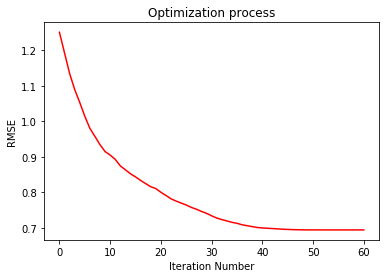

In [54]:
plt.plot(crisis_yy,color='R')
plt.title('Optimization process')
plt.xlabel('Iteration Number')
plt.ylabel('RMSE')

Text(0, 0.5, 'y_axis')

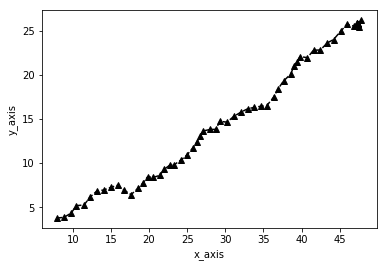

In [55]:
plt.plot(crisis_bestX,crisis_bestY,'^--',color='black')
plt.xlabel('x_axis')
plt.ylabel('y_axis')

In [58]:
X_train_RF, X_test_RF, y_train_RF, y_test_RF = dataPreprocessing(df_resample, IsSelected=False, HasCrisis=False, GenMoreData=0)

In [59]:
# 迭代50次
crisis_yy, crisis_bestX, crisis_bestY = foa(50,10, X_train_RF, X_test_RF, np.argmax(y_train_RF, axis=1), np.argmax(y_test_RF, axis=1))

尋優開始
初始RMSE最佳為1.1404353436154002, 正確率為0.4950884086444008, 平滑涵數為0.0823940322870154
--------------------------------------
最佳化開始
--------------------------------------
迭代第1次
GRNN 平滑涵數0.07619294547833422
目前正確率為0.4950884086444008
目前RMSE為1.1404353436154002
更新RMSE最佳為1.0957326492079922
更新正確率最佳為0.5068762278978389
--------------------------------------
迭代第2次
GRNN 平滑涵數0.07102603681276305
目前正確率為0.5068762278978389
目前RMSE為1.0957326492079922
更新RMSE最佳為1.0564943923934909
更新正確率最佳為0.5117878192534381
--------------------------------------
迭代第3次
GRNN 平滑涵數0.06688103394231962
目前正確率為0.5117878192534381
目前RMSE為1.0564943923934909
更新RMSE最佳為1.024228714314165
更新正確率最佳為0.5245579567779961
--------------------------------------
迭代第4次
GRNN 平滑涵數0.06337838168890306
目前正確率為0.5245579567779961
目前RMSE為1.024228714314165
更新RMSE最佳為0.996923772510543
--------------------------------------
迭代第5次
GRNN 平滑涵數0.06147289616530284
目前正確率為0.5245579567779961
目前RMSE為0.996923772510543
更新RMSE最佳為0.9822210419527972
更新正確率最佳為0.5265225933202358
----

Text(0, 0.5, 'RMSE')

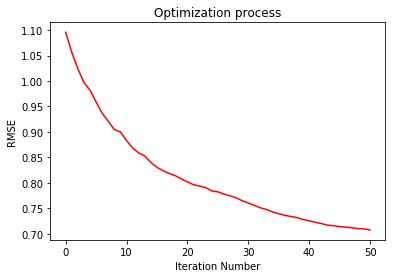

In [60]:
plt.plot(crisis_yy,color='R')
plt.title('Optimization process')
plt.xlabel('Iteration Number')
plt.ylabel('RMSE')

Text(0, 0.5, 'y_axis')

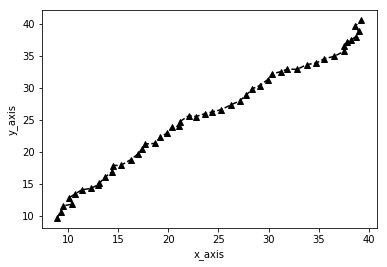

In [61]:
plt.plot(crisis_bestX,crisis_bestY,'^--',color='black')
plt.xlabel('x_axis')
plt.ylabel('y_axis')